In [1]:
import json
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

np.random.seed(123)
sns.set_style('darkgrid')
pd.set_option('display.max_colwidth', None)

In [2]:
apartments = pd.read_csv('resources/data/apartments_train.csv')
buildings = pd.read_csv('resources/data/buildings_train.csv')
data = pd.merge(apartments, buildings.set_index('id'), how='left', left_on='building_id', right_index=True)

apartments_test = pd.read_csv('resources/data/apartments_test.csv')
buildings_test = pd.read_csv('resources/data/buildings_test.csv')
data_test = pd.merge(apartments_test, buildings_test.set_index('id'), how='left', left_on='building_id', right_index=True)



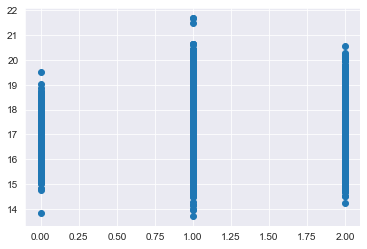

In [13]:
data_phone = data.loc[ ~data["phones"].isna()]
plt.scatter(data_phone["phones"], np.log(data_phone["price"]))


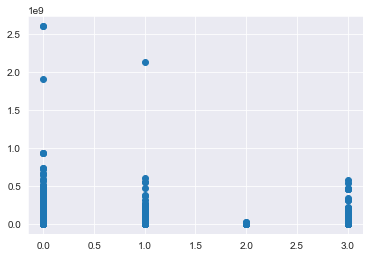

In [17]:
#plt.scatter(data["condition"], data["price"])
plt.scatter(data["heating"], data["price"])


# XGBoost

In [40]:
import xgboost as xgb
import sklearn.model_selection as model_selection

def root_mean_squared_log_error(y_true, y_pred):
    # Alternatively: sklearn.metrics.mean_squared_log_error(y_true, y_pred) ** 0.5
    assert (y_true >= 0).all() 
    assert (y_pred >= 0).all()
    log_error = np.log1p(y_pred) - np.log1p(y_true)  # Note: log1p(x) = log(1 + x)
    return np.mean(log_error ** 2) ** 0.5


data_train, data_valid = model_selection.train_test_split(data, test_size=0.33, stratify=np.log(data.price).round())
X_train = data_train[['latitude', 'longitude']]
y_train = data_train.loc[X_train.index].price
X_valid = data_valid[['latitude', 'longitude']]
y_valid = data_valid.loc[X_valid.index].price

dtrain = xgb.DMatrix(X_train, label = y_train)
dval = xgb.DMatrix(X_valid)
param = {'max_depth': 2, 'eta': 1e3, 'objective': 'reg:squaredlogerror'}
num_round = 10000

bst = xgb.train(param, dtrain, num_round)
preds_train = bst.predict(dtrain)
preds_valid = bst.predict(dval)
# Pretty darn shitty results                                
print(root_mean_squared_log_error(preds_train, y_train))
print(root_mean_squared_log_error(preds_valid, y_valid))




/Users/jimtotland/anaconda3/lib/python3.7/site-packages/sklearn/utils/__init__.py:806: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return floored.astype(np.int)
/Users/jimtotland/anaconda3/lib/python3.7/site-packages/sklearn/utils/__init__.py:806: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your c

9.215685467270928
9.22078866855869
